In [4]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import time
from drone_vrp import*

In [5]:
import multiprocessing

#### Replace the Fitness(population[i]).routeDistance() to our own objective function. ####
#### Replace  otherParamters to our own parameters which needed to initial and caculate the objective function

#### Population will be the list of customer service station route ####

#### Fitness(population[i]).routeDistance() will be the service time from route ####

#### So that  fitnessResults will be list the 1/serviceTime from the list of route ####

In [6]:
def multiprocessing_getServiceTime(population,dvrp,i fitnessResults):
    print('start to run:', i)
    dvrp1 = copy.deepcopy(dvrp)
    dvrp1.customers = population[i]
    dvrp1.split_route();
    fitnessResults[i] = 1/dvrp1.objective()
    return 
    

SyntaxError: invalid syntax (<ipython-input-6-37ea8a701d5e>, line 1)

In [7]:
def rankRoutes(population, dvrp):
    fitnessResults = {}
    for i in range(0,len(population)):
        print('check population',i)
        #print('population id:')
        #for custom in population[i]:
         #   print(custom.id)
        dvrp1 = copy.deepcopy(dvrp)
        dvrp1.customers = population[i]
        dvrp1.split_route();
        fitnessResults[i] = 1/dvrp1.objective()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

#### Main method of GA, please replace the otherParamters with our own Parameters need####

next gen 100 parent -> spiltroute for each parent -> 100 results -> rankResult -> 20 best parent +80 child -> 100 child ->1% mutate -> next gen 100 parent -> loop

Mutate 1% (city1, city2 ..... cityn) -> mutate (city1, cityn ..... city2)

loop next gen 500 -> 100 gens ->best 1 output

In [24]:
'''
Description: Main method of GA
Reference: 
https://levelup.gitconnected.com/how-to-implement-a-traveling-salesman-problem-genetic-algorithm-in-python-ea32c7bef20f
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
https://github.com/rocreguant/personal_blog/blob/main/Genetic_Algorithm_Python_Example/Traveling_Salesman_Problem.ipynb
https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb

'''

## Create our initial population
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    
    return route

#Create first "population" (list of routes)
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

#Create mating pool
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
        print('len of selectionResults', len(selectionResults))
    return selectionResults

#Create a crossover function for two parents to create one child
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

#Create function to run crossover over full mating pool
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(1,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

#Create function to run mutation over entire population
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

#Put all steps together to create the next generation
def nextGeneration(currentGen, eliteSize, mutationRate, otherParamters):
    popRanked = rankRoutes(currentGen, otherParamters)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration,popRanked

#Final step: create the genetic algorithm
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, dvrp):
    print(population)
    pop = initialPopulation(popSize, population)
    popRanked = rankRoutes(pop, dvrp);
    print("Initial Service Time: " + str(1 / popRanked[0][1]))
    progress = []
    progress.append(1 / popRanked[0][1])
    for i in range(0, generations):
        print('start generations:', i+1)
        pop,popRanked = nextGeneration(pop, eliteSize, mutationRate, dvrp)
        
        progress.append(1 / popRanked[0][1])
    
    print("Final Service Time: " + str(1 / popRanked[0][1]))
    plt.plot(progress)
    plt.ylabel('Service Time')
    plt.xlabel('Generation')
    plt.show()
    bestRouteIndex = popRanked[0][0]
    bestRoute = pop[bestRouteIndex]
    dvrp1 = copy.deepcopy(dvrp)
    dvrp1.customers = bestRoute
    dvrp1.split_route();
    
    return dvrp1


## Running the genetic algorithm

### Please replace the cityList with our own Customers Service Satation from either hardcode or data import,
### Please replace the otherParamters with our own Parameters needed for mode from either hardcode or data import

[<drone_vrp.Customer object at 0x000002897F9B38B0>, <drone_vrp.Customer object at 0x000002897F9B3910>, <drone_vrp.Customer object at 0x000002897F9B3940>, <drone_vrp.Customer object at 0x000002897F9B34F0>, <drone_vrp.Customer object at 0x000002897F9B3970>, <drone_vrp.Customer object at 0x000002897F9B39A0>, <drone_vrp.Customer object at 0x000002897F9B39D0>, <drone_vrp.Customer object at 0x000002897F9B3A00>, <drone_vrp.Customer object at 0x000002897F9B3580>, <drone_vrp.Customer object at 0x000002897F9B3A30>, <drone_vrp.Customer object at 0x000002897F9B3A90>, <drone_vrp.Customer object at 0x000002897F9B3AC0>, <drone_vrp.Customer object at 0x000002897F9B3B20>, <drone_vrp.Customer object at 0x000002897F9B3A60>, <drone_vrp.Customer object at 0x000002897F9B3B80>, <drone_vrp.Customer object at 0x000002897F9B3B50>, <drone_vrp.Customer object at 0x000002897F9B3BB0>, <drone_vrp.Customer object at 0x000002897F9B3BE0>, <drone_vrp.Customer object at 0x000002897F9B3C40>, <drone_vrp.Customer object at 

check population 1
check population 2
check population 3
check population 4
check population 5
check population 6
check population 7
check population 8
check population 9
check population 10
check population 11
check population 12
check population 13
check population 14
check population 15
check population 16
check population 17
check population 18
check population 19
start generations: 5
check population 0
check population 1
check population 2
check population 3
check population 4
check population 5
check population 6
check population 7
check population 8
check population 9
check population 10
check population 11
check population 12
check population 13
check population 14
check population 15
check population 16
check population 17
check population 18
check population 19
len of selectionResults 3
len of selectionResults 4
len of selectionResults 5
len of selectionResults 6
len of selectionResults 7
len of selectionResults 8
len of selectionResults 9
len of selectionResults 10
len of se

check population 8
check population 9
check population 10
check population 11
check population 12
check population 13
check population 14
check population 15
check population 16
check population 17
check population 18
check population 19
Final Service Time: 1800.9999999999998


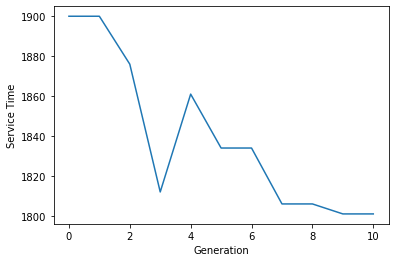

check population 0
check population 1
check population 2
check population 3
check population 4
check population 5
check population 6
check population 7
check population 8
check population 9
check population 10
check population 11
check population 12
check population 13
check population 14
check population 15
check population 16
check population 17
check population 18
check population 19
running time:  4141.154933691025


In [11]:
if __name__ == '__main__':
    config_file = "config.ini"
    data_type = "data-complex"
    
    # # load data and random seed
    parsed = Parser(config_file, data_type)
    
    dvrp = DVRP(parsed.warehouses, parsed.customers, parsed.trucks, parsed.drones, parsed.map_size)


    start = time.time()

    
    bestRoute = geneticAlgorithm(population=dvrp.customers, popSize=20, eliteSize=2, mutationRate=0.01, generations=10,dvrp=dvrp)
    
    end = time.time()
    print('running time: ',end - start)
    

[<drone_vrp.Customer object at 0x000002897FB9A2E0>, <drone_vrp.Customer object at 0x000002897FB9AD60>, <drone_vrp.Customer object at 0x000002897FB9A130>, <drone_vrp.Customer object at 0x000002897FC58A00>, <drone_vrp.Customer object at 0x000002897FC587F0>, <drone_vrp.Customer object at 0x000002897FC58520>, <drone_vrp.Customer object at 0x000002897FC58490>, <drone_vrp.Customer object at 0x000002897FC58250>, <drone_vrp.Customer object at 0x000002897FC58280>, <drone_vrp.Customer object at 0x000002897FC58B20>, <drone_vrp.Customer object at 0x000002897FC584F0>, <drone_vrp.Customer object at 0x000002897FC586A0>, <drone_vrp.Customer object at 0x000002897FC586D0>, <drone_vrp.Customer object at 0x000002897FC58550>, <drone_vrp.Customer object at 0x000002897FC58130>]
check population 0
check population 1
check population 2
check population 3
check population 4
check population 5
check population 6
check population 7
check population 8
check population 9
check population 10
check population 11
chec

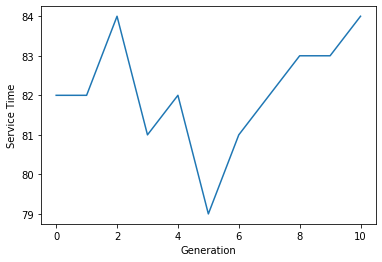

running time:  127.3099615573883


In [26]:
if __name__ == '__main__':
    config_file = "config.ini"
    data_type = "data-medium"
    
    # # load data and random seed
    parsed = Parser(config_file, data_type)
    
    dvrp = DVRP(parsed.warehouses, parsed.customers, parsed.trucks, parsed.drones, parsed.map_size)


    start = time.time()

    
    bestRoute = geneticAlgorithm(population=dvrp.customers, popSize=20, eliteSize=2, mutationRate=0.01, generations=10,dvrp=dvrp)
    
    end = time.time()
    print('running time: ',end - start)